In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
tfd = tf.contrib.distributions

/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cc/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: P

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
z_dim = 2
batch_size = 100
nb_steps = 50000
eps = 1e-7
K = 16

In [3]:
def render_images(np_x):
    np_x = np_x.reshape((10,10,28,28))
    np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
    np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
    x_img = np.squeeze(np_x)
    plt.imshow(x_img, cmap='Greys_r')
    plt.show()

In [4]:
def encoder(x, z_dim=20, reuse=False):
    with tf.variable_scope("encoder", reuse=reuse):
        l1 = tf.layers.dense(x, 512, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 256, activation=tf.nn.relu)
        mu = tf.layers.dense(l2, z_dim, activation=None)
        sigma = 1e-6 + tf.nn.softplus(tf.layers.dense(l2, z_dim, activation=None))
        return mu, sigma

In [5]:
def decoder(z, z_dim=20, reuse=False):
    with tf.variable_scope("decoder", reuse=reuse):
        l1 = tf.layers.dense(z, 256, activation=tf.nn.relu)
        l2 = tf.layers.dense(l1, 512, activation=tf.nn.relu)
        x_hat = tf.layers.dense(l2, 784, activation=tf.nn.sigmoid)
        return x_hat

In [6]:
m = lambda x: -1 + tf.log(1 + tf.exp(x))
h = lambda x: tf.tanh(x)
h_prime = lambda x: 1 - tf.tanh(x) ** 2

In [7]:
def planar_flow(z0, length=8, reuse=False):
    z_prev = z0
    for k in range(length):
        with tf.variable_scope('layer_%d' % k, reuse=reuse):
            u = tf.get_variable('u', dtype=tf.float32, shape=(1, z_dim))
            w = tf.get_variable('w', dtype=tf.float32, shape=(1, z_dim))
            b = tf.get_variable('b', dtype=tf.float32, shape=())
            u_hat = (m(tf.tensordot(w, u, 2)) - tf.tensordot(w, u, 2)) * (w / tf.norm(w)) + u
            z_prev = z_prev + u_hat * h(tf.expand_dims(tf.reduce_sum(z_prev * w, -1), -1) + b)
    zK = z_prev
    return zK

In [8]:
def SLDJ(z0, length=8, reuse=False):
    z_prev = z0
    sum_log_det_jacob = 0.
    for k in range(length):
        with tf.variable_scope('layer_%d' % k, reuse=reuse):
            u = tf.get_variable('u', dtype=tf.float32, shape=(1, z_dim))
            w = tf.get_variable('w', dtype=tf.float32, shape=(1, z_dim))
            b = tf.get_variable('b', dtype=tf.float32, shape=())
            u_hat = (m(tf.tensordot(w, u, 2)) - tf.tensordot(w, u, 2)) * (w / tf.norm(w)) + u
            affine = h_prime(tf.expand_dims(tf.reduce_sum(z_prev * w, -1), -1) + b) * w
            sum_log_det_jacob += tf.log(eps + tf.abs(1 + tf.reduce_sum(affine * u_hat, -1)))
    return sum_log_det_jacob

In [9]:
x = tf.placeholder(tf.float32, [batch_size, 784])
prior = tfd.MultivariateNormalDiag(loc=tf.zeros(z_dim), scale_diag=tf.ones(z_dim))
mu, sigma = encoder(x, z_dim=z_dim)
qz0_x = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
z0 = qz0_x.sample()
zK = planar_flow(z0, length=K)
x_hat = decoder(zK)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlo

In [10]:
px_z = tf.reduce_mean(tf.reduce_sum(x * tf.log(x_hat + 1e-8) + (1 - x) * tf.log(1 - x_hat + 1e-8), [1]))
pz = prior.log_prob(zK)
qz0 = qz0_x.log_prob(z0)
sum_log_det_jacob = SLDJ(z0, length=K, reuse=True)
loss = tf.reduce_mean(qz0 - px_z - pz - sum_log_det_jacob)

In [11]:
optim_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
init_op = tf.global_variables_initializer()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [13]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [14]:
sess.run(init_op)
start_time = time.time()
for stp in range(1, nb_steps+1):
    x_np, _ = mnist.train.next_batch(batch_size)
    _, loss_np = sess.run([optim_op, loss], feed_dict={x: x_np})
    if stp % 5000 == 0:
        end_time = time.time()
        print('Step: {:d} in {:.2f}s :: Loss: {:.3f}'.format(stp, end_time - start_time, loss_np))
        start_time = end_time

Step: 5000 in 107.53s :: Loss: 149.980
Step: 10000 in 104.79s :: Loss: 136.518
Step: 15000 in 104.35s :: Loss: 140.765
Step: 20000 in 104.51s :: Loss: 135.276
Step: 25000 in 104.22s :: Loss: 137.661
Step: 30000 in 104.33s :: Loss: 138.749
Step: 35000 in 103.71s :: Loss: 135.992
Step: 40000 in 103.78s :: Loss: 133.050
Step: 45000 in 103.96s :: Loss: 130.272
Step: 50000 in 103.86s :: Loss: 132.999


In [15]:
total_loss = 0.
total_rec_loss = 0.
n_batches = 0.
zKs = []
for i in range(0, mnist.test.images.shape[0], batch_size):
    x_np = mnist.test.images[i:(i+batch_size)]
    zK_np, rec_np, loss_np = sess.run([zK, px_z, loss], feed_dict={x: x_np})
    total_loss += loss_np
    total_rec_loss += rec_np
    n_batches += 1
    zKs.append(zK_np)
avg_loss = total_loss/n_batches
avg_rec_loss = total_rec_loss/n_batches
print(avg_loss, -avg_rec_loss)

137.1191562652588 131.80827850341797


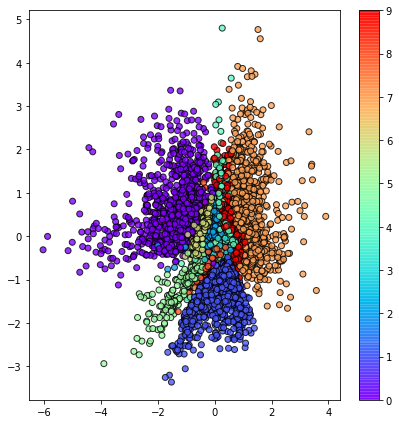

In [17]:
if z_dim == 2:
    zK_test = np.vstack(zKs)
    y_test = np.argmax(mnist.test.labels, axis=1)
    plt.figure(figsize=(6, 6))
    plt.scatter(zK_test[:, 0], zK_test[:, 1], c=y_test, alpha=0.8, cmap='rainbow', edgecolor='k')
    plt.colorbar()
    plt.tight_layout()